In [1]:
import pandas as pd
import scanpy as sc
import pickle
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import os

degs_all = pickle.load(open('../../results/degs_all.pkl', 'rb'))

In [2]:
######################## scGPT ########################
# Adamson
def run_scgpt_adamson():
    adamson = sc.read_h5ad("../../data/Data_GEARS/adamson/perturb_processed.h5ad")
    degs_names = degs_all['adamson']
    ctrl = adamson[adamson.obs["condition"] == "ctrl"].X.toarray().mean(axis=0)
    ctrl = pd.Series(ctrl, index=adamson.var.index)

    all_pred = []
    all_true = []
    for split in range(1, 6):
        with open(f"../extra/foundation/scgpt/adamson/mean_res_{split}.pkl", "rb") as f:
            adamson_res = pickle.load(f)
            pred_i = adamson_res["pred"]
            pred_i.columns = adamson.var.index
            true_i = adamson_res["truth"]
            true_i.columns = adamson.var.index
            all_pred.append(pred_i)
            all_true.append(true_i)
    pred = pd.concat(all_pred)
    true = pd.concat(all_true)

    norm_mse = []
    minus_pcc = []
    for i in range(len(pred)):
        pert = pred.index[i]
        degs_i = degs_names[pert]
        pred_i = pred.iloc[i, degs_i].values
        true_i = true.iloc[i, degs_i].values
        ctrl_i = ctrl.iloc[degs_i].values
        norm_mse.append(mse(pred_i, true_i) / mse(ctrl_i, true_i))
        minus_pcc.append(1 - pearsonr(pred_i - ctrl_i, true_i - ctrl_i)[0])
    scGPT_metric_adamson = pd.DataFrame({"Normalized MSE": norm_mse, "1 - PCC": minus_pcc}, index=pred.index)
    return scGPT_metric_adamson


# Norman
def run_scgpt_norman():
    norman = sc.read_h5ad("../../data/Data_GEARS/norman/perturb_processed.h5ad")
    degs_names = degs_all['norman']
    ctrl = norman[norman.obs["condition"] == "ctrl"].X.toarray().mean(axis=0)
    ctrl = pd.Series(ctrl, index=norman.var.index)

    all_pred = []
    all_true = []
    for split in range(1, 6):
        with open(f"../extra/foundation/scgpt/norman/split/norman_simulation_{split}_0.75_subgroup.pkl", "rb") as f:
            norman_split = pickle.load(f)['test_subgroup']
            pert_to_group = {p: g.split("_")[1] for g, ps in norman_split.items() for p in ps}
            subgroup_i = pd.DataFrame.from_dict(pert_to_group, orient='index', columns=['subgroup'])

        with open(f"../extra/foundation/scgpt/norman/mean_res_{split}.pkl", "rb") as f:
            norman_res = pickle.load(f)

            pred_i = norman_res["pred"]
            pred_i.columns = norman.var.index
            pred_i = pred_i.join(subgroup_i)

            true_i = norman_res["truth"]
            true_i.columns = norman.var.index
            true_i = true_i.join(subgroup_i)

            all_pred.append(pred_i)
            all_true.append(true_i)
    pred = pd.concat(all_pred)
    true = pd.concat(all_true)

    norm_mse = []
    minus_pcc = []
    subgroup = []
    for i in range(len(pred)):
        pert = pred.index[i]
        pert = '+'.join(sorted(pert.split('+')))
        degs_i = degs_names[pert]
        pred_i = pred.iloc[i, degs_i].values.astype(float)
        true_i = true.iloc[i, degs_i].values.astype(float)
        ctrl_i = ctrl.iloc[degs_i].values

        norm_mse.append(mse(pred_i, true_i) / mse(ctrl_i, true_i))
        minus_pcc.append(1 - pearsonr(pred_i - ctrl_i, true_i - ctrl_i)[0])
        subgroup.append(pred.iloc[i]['subgroup'])
    scGPT_metric_norman = pd.DataFrame({"Normalized MSE": norm_mse, "1 - PCC": minus_pcc, "subgroup": subgroup}, index=pred.index)
    return scGPT_metric_norman


scGPT_metric_adamson = run_scgpt_adamson().assign(Method='scGPT')
scGPT_metric_norman = run_scgpt_norman().assign(Method='scGPT')

In [3]:
######################## scELMo ########################
# Adamson
# because these genes can not be predicted by scELMo
exclude_genes = ['GARS', 'WDR61', 'C12orf45', 'INTS2', 'POLR2B', 'ZNF720', 'PRELID3B', 'C5orf30', 'SPATA5L1']
def read_metric(path, dataset, method):
    with open(path, 'rb') as f:
        dict_split = pickle.load(f)
        split = {}
        for k, v in dict_split.items():
            # get perturbation condition key
            if any(gene in k for gene in exclude_genes):
                continue
            true, pred, ctrl, _ = v.values()
            if method == 'biolord':
                pert_key = k.split('_')[1]
            elif method == 'gears':
                if dataset == 'adamson':
                    pert_key = f'{k}+ctrl'
                else:
                    pert_key = k
            if dataset == 'norman':
                pert_key = '+'.join(sorted(pert_key.split('+')))
            
            # compute metrics
            de_idx = degs_all[dataset][pert_key]
            true = true[de_idx]
            pred = pred[de_idx]
            ctrl = ctrl[de_idx]
            mse_k = mse(true, pred)/mse(true, ctrl)
            pear_k = pearsonr(true-ctrl, pred-ctrl)[0]
            split[k] = {'Normalized MSE':mse_k, '1 - PCC': 1 - pear_k}
        split = pd.DataFrame.from_dict(split, orient='index')
    return split


def run_scelmo_adamson():
    df = []
    for split in range(1, 6):
        adamson_res = read_metric(f"../extra/foundation/scelmo/adamson/qrsh_{split}.pkl", 'adamson', 'gears')
        df.append(adamson_res)
    scELMo_metric_adamson = pd.concat(df)
    return scELMo_metric_adamson

# Norman
def run_scelmo_norman():
    df = []
    for i in range(1,6):
        scelmo_single = read_metric(f'../extra/foundation/scelmo/norman/qrsh_unseen_single_split{i}.pkl', 'norman', 'gears').assign(subgroup='single')
        scelmo_seen0 = read_metric(f'../extra/foundation/scelmo/norman/qrsh_combo_seen0_split{i}.pkl', 'norman', 'gears').assign(subgroup='seen0')
        scelmo_seen1 = read_metric(f'../extra/foundation/scelmo/norman/qrsh_combo_seen1_split{i}.pkl', 'norman', 'gears').assign(subgroup='seen1')
        scelmo_seen2 = read_metric(f'../extra/foundation/scelmo/norman/qrsh_combo_seen2_split{i}.pkl', 'norman', 'gears').assign(subgroup='seen2')
        df.append(pd.concat([scelmo_single, scelmo_seen0, scelmo_seen1, scelmo_seen2]))
    scELMo_metric_norman = pd.concat(df)
    return scELMo_metric_norman


scELMo_metric_adamson = run_scelmo_adamson().assign(Method='scELMo')
scELMo_metric_norman = run_scelmo_norman().assign(Method='scELMo')

In [4]:
######################## Others ########################
others_adamson = pd.read_csv("../../results/adamson.csv", index_col=0)
others_adamson = others_adamson.rename(columns={'NormMSE': 'Normalized MSE', '1-PCC': '1 - PCC'})
others_adamson = others_adamson[['Normalized MSE', '1 - PCC', 'Method']]

others_norman = pd.read_csv("../../results/norman.csv", index_col=0)
others_norman = others_norman.rename(columns={'NormMSE': 'Normalized MSE', '1-PCC': '1 - PCC'})
others_norman = others_norman[['Normalized MSE', '1 - PCC', 'Method', 'subgroup']]

adamson = pd.concat([scGPT_metric_adamson, scELMo_metric_adamson, others_adamson])
norman = pd.concat([scGPT_metric_norman, scELMo_metric_norman, others_norman])

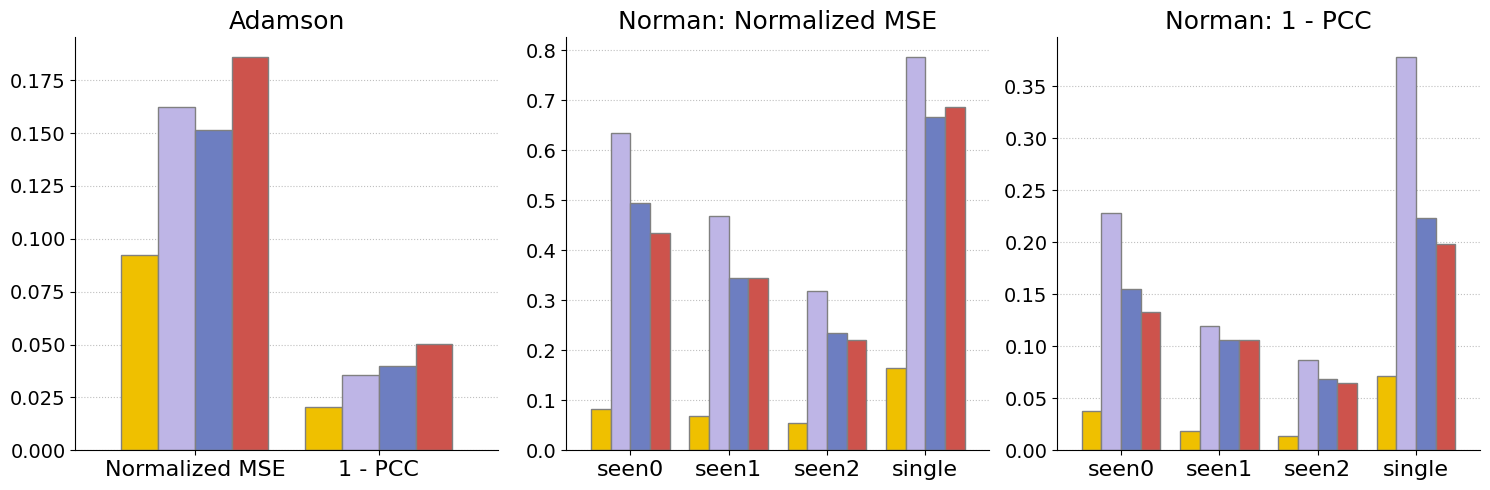

In [5]:
######################## Plot ########################
# Order and Colors
order = ["Scouter", "scGPT", "scELMo", "GEARS"]
colors = ["#efc000", "#beb5e6", "#6d7ec1", "#cd534c"]
# Adamson Data
adamson_mse = adamson.groupby("Method")["Normalized MSE"].median().reindex(order)
adamson_pcc = adamson.groupby("Method")["1 - PCC"].median().reindex(order)
df_adamson = pd.DataFrame({"Normalized MSE": adamson_mse, "1 - PCC": adamson_pcc}).T
# Norman Data
norman_mse = norman.groupby(["subgroup", "Method"])["Normalized MSE"].median().unstack()[order]
norman_pcc = norman.groupby(["subgroup", "Method"])["1 - PCC"].median().unstack()[order]


fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1行3列

# Adamson
df_adamson.plot(
    kind="bar",
    color=colors,
    edgecolor="gray",
    width=0.8,
    legend=False,
    ax=axes[0]
)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].yaxis.grid(True, linestyle=':', color='gray', alpha=0.5, zorder=0)
axes[0].set_axisbelow(True)
axes[0].set_title("Adamson", fontsize=18)
axes[0].set_xlabel("")
axes[0].set_ylabel("")
axes[0].tick_params(axis='x', rotation=0, labelsize=16)
axes[0].tick_params(axis='y', labelsize=14)

# Norman MSE
norman_mse.plot(
    kind='bar',
    color=colors,
    edgecolor="gray",
    width=0.8,
    legend=False,
    ax=axes[1]
)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].yaxis.grid(True, linestyle=':', color='gray', alpha=0.5, zorder=0)
axes[1].set_axisbelow(True)
axes[1].set_title("Norman: Normalized MSE", fontsize=18)
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].tick_params(axis='x', rotation=0, labelsize=16)
axes[1].tick_params(axis='y', labelsize=14)

# Norman 1 - PCC
norman_pcc.plot(
    kind='bar',
    color=colors,
    edgecolor="gray",
    width=0.8,
    legend=False,
    ax=axes[2]
)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].yaxis.grid(True, linestyle=':', color='gray', alpha=0.5, zorder=0)
axes[2].set_axisbelow(True)
axes[2].set_title("Norman: 1 - PCC", fontsize=18)
axes[2].set_xlabel("")
axes[2].set_ylabel("")
axes[2].tick_params(axis='x', rotation=0, labelsize=16)
axes[2].tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.show()